Registering controller: SpectraChartController
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> Browsing ./sample_data
No train_group file found for ./sample_data.
No test_group file found for ./sample_data.


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
D:\Workspace\ML\NIRS\nirs4all\nirs4all\controllers\chart\op_spectra_charts.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



Python Dataset:
 FeatureBlock with 1 sources and 189 samples
Source 0: FeatureSource(shape=(189, 1, 2151), dtype=float32, processing_ids=['raw'], mean=0.46620577573776245, variance=0.1492786705493927)
Unique augmentations: [None]
Index:
shape: (189, 8)
┌─────┬────────┬────────┬───────────┬───────┬────────┬────────────┬──────────────┐
│ row ┆ sample ┆ origin ┆ partition ┆ group ┆ branch ┆ processing ┆ augmentation │
│ --- ┆ ---    ┆ ---    ┆ ---       ┆ ---   ┆ ---    ┆ ---        ┆ ---          │
│ i32 ┆ i32    ┆ i32    ┆ cat       ┆ i8    ┆ i8     ┆ cat        ┆ cat          │
╞═════╪════════╪════════╪═══════════╪═══════╪════════╪════════════╪══════════════╡
│ 0   ┆ 0      ┆ null   ┆ train     ┆ 0     ┆ 0      ┆ raw        ┆ null         │
│ 1   ┆ 1      ┆ null   ┆ train     ┆ 0     ┆ 0      ┆ raw        ┆ null         │
│ 2   ┆ 2      ┆ null   ┆ train     ┆ 0     ┆ 0      ┆ raw        ┆ null         │
│ 3   ┆ 3      ┆ null   ┆ train     ┆ 0     ┆ 0      ┆ raw        ┆ null         │

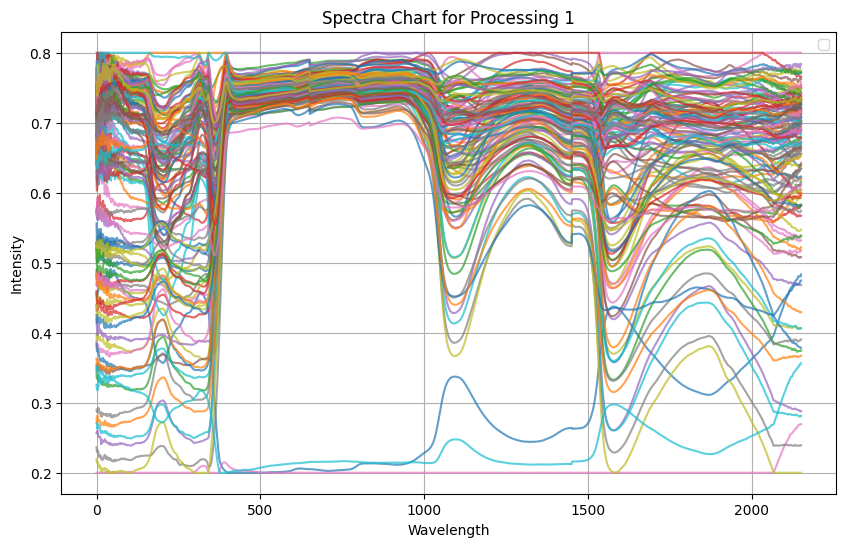

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataset state after step 2:
FeatureBlock with 1 sources and 189 samples
Source 0: FeatureSource(shape=(189, 1, 2151), dtype=float32, processing_ids=['raw_MinMax_1'], mean=0.6808587312698364, variance=0.011851510033011436)
Unique augmentations: [None]
Index:
shape: (189, 8)
┌─────┬────────┬────────┬───────────┬───────┬────────┬──────────────┬──────────────┐
│ row ┆ sample ┆ origin ┆ partition ┆ group ┆ branch ┆ processing   ┆ augmentation │
│ --- ┆ ---    ┆ ---    ┆ ---       ┆ ---   ┆ ---    ┆ ---          ┆ ---          │
│ i32 ┆ i32    ┆ i32    ┆ cat       ┆ i8    ┆ i8     ┆ cat          ┆ cat          │
╞═════╪════════╪════════╪═══════════╪═══════╪════════╪══════════════╪══════════════╡
│ 0   ┆ 0      ┆ null   ┆ train     ┆ 0     ┆ 0      ┆ raw_MinMax_1 ┆ null         │
│ 1   ┆ 1      

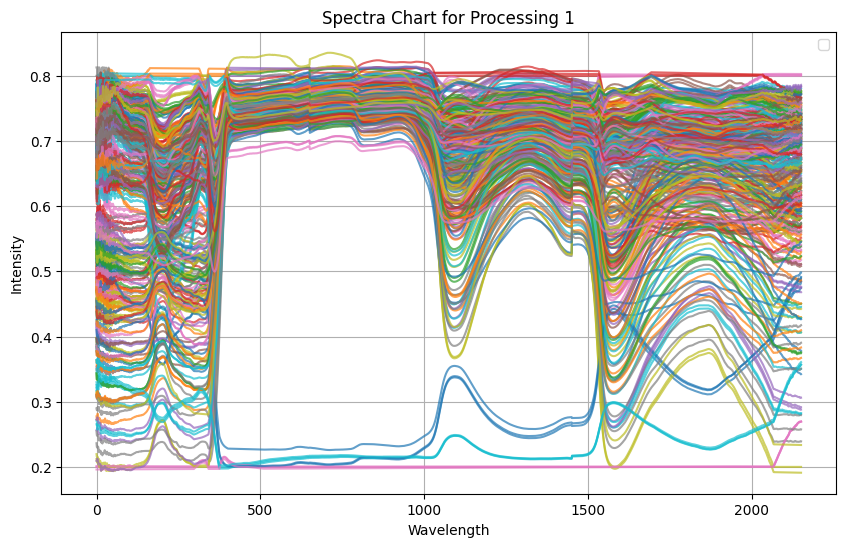

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataset state after step 6:
FeatureBlock with 1 sources and 449 samples
Source 0: FeatureSource(shape=(449, 1, 2151), dtype=float32, processing_ids=['raw_MinMax_1'], mean=0.6812826991081238, variance=0.012882026843726635)
Unique augmentations: ['aug_1_Rotate_5', 'aug_0_Rotate_4', None]
Index:
shape: (449, 8)
┌─────┬────────┬────────┬───────────┬───────┬────────┬──────────────┬────────────────┐
│ row ┆ sample ┆ origin ┆ partition ┆ group ┆ branch ┆ processing   ┆ augmentation   │
│ --- ┆ ---    ┆ ---    ┆ ---       ┆ ---   ┆ ---    ┆ ---          ┆ ---            │
│ i32 ┆ i32    ┆ i32    ┆ cat       ┆ i8    ┆ i8     ┆ cat          ┆ cat            │
╞═════╪════════╪════════╪═══════════╪═══════╪════════╪══════════════╪════════════════╡
│ 0   ┆ 0      ┆ null   ┆ train     ┆ 0     ┆ 0      ┆

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
D:\Workspace\ML\NIRS\nirs4all\nirs4all\controllers\chart\op_spectra_charts.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


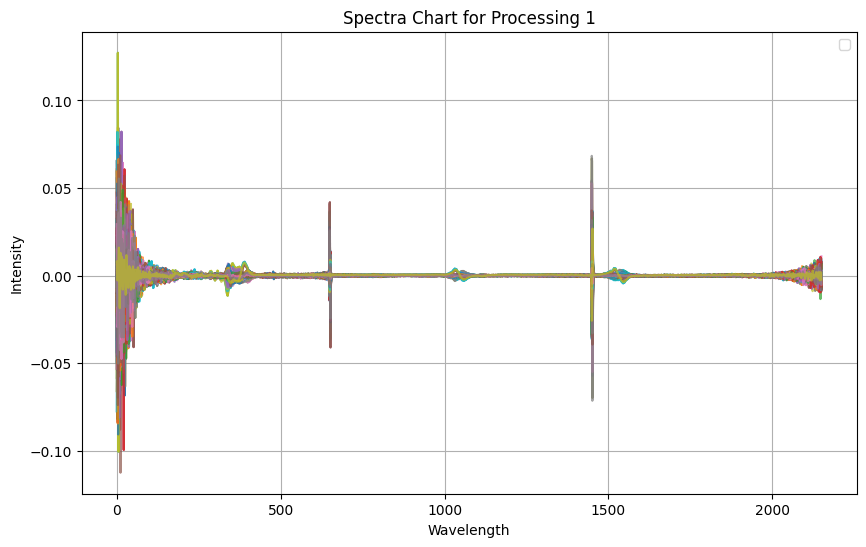

(449, 2151)


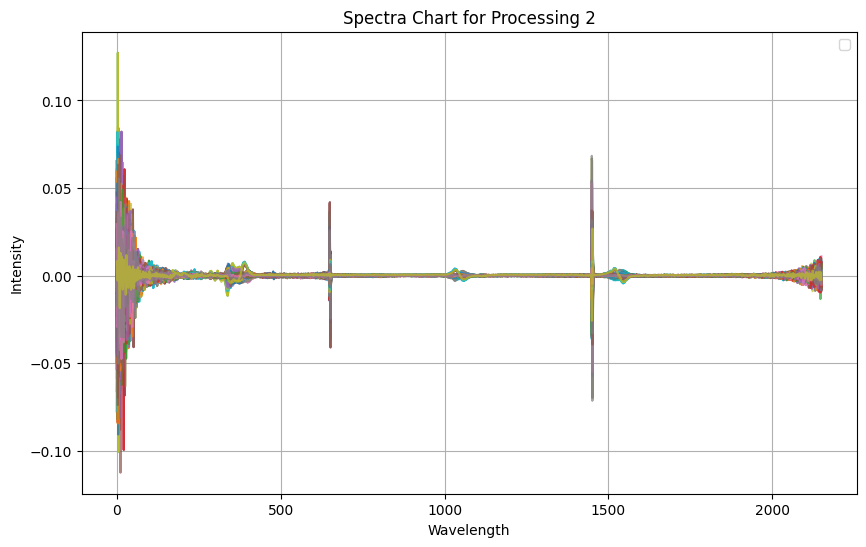

(449, 2151)


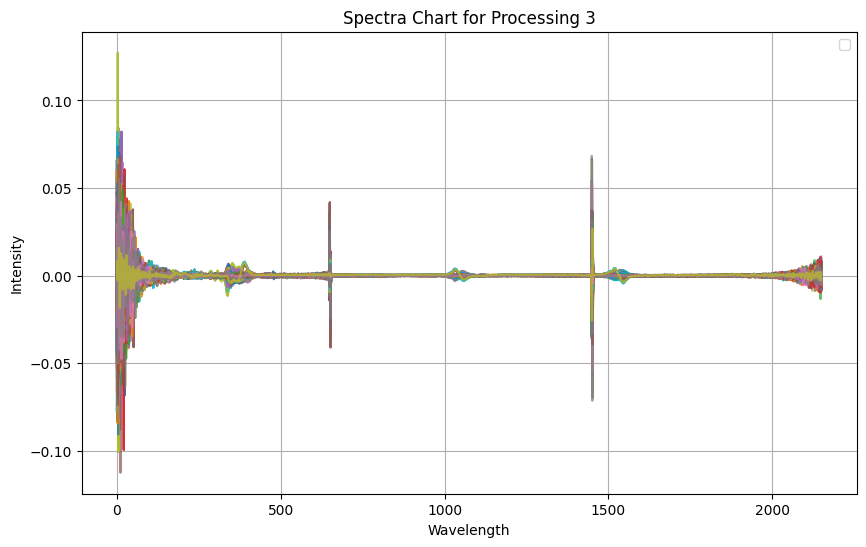

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataset state after step 13:
FeatureBlock with 1 sources and 449 samples
Source 0: FeatureSource(shape=(449, 3, 2151), dtype=float32, processing_ids=['raw_MinMax_1', 'raw_MinMax_1fa_1_Savitz_9', 'raw_MinMax_1fa_2_Standa_11_Gaussi_12'], mean=8.228716102606781e-13, variance=8.132333277899306e-06)
Unique augmentations: [None, 'aug_1_Rotate_5', 'aug_0_Rotate_4']
Index:
shape: (1_347, 8)
┌──────┬────────┬────────┬───────────┬───────┬────────┬─────────────────────────────┬──────────────┐
│ row  ┆ sample ┆ origin ┆ partition ┆ group ┆ branch ┆ processing                  ┆ augmentation │
│ ---  ┆ ---    ┆ ---    ┆ ---       ┆ ---   ┆ ---    ┆ ---                         ┆ ---          │
│ i32  ┆ i32    ┆ i32    ┆ cat       ┆ i8    ┆ i8     ┆ cat                         ┆ cat          │
╞══════╪═

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [ ]:
%load_ext autoreload
%autoreload 2

from nirs4all.pipeline.runner import PipelineRunner
from nirs4all.pipeline.config import PipelineConfig
from nirs4all.dataset import SpectroDataset
from sample import config as python_config
from nirs4all.dataset.loader import get_dataset
from nirs4all.controllers.registry import reset_registry
from nirs4all.controllers import *

dataset_py = get_dataset(python_config["dataset"])
print("\n", "="*200, "\nPython Dataset:\n", dataset_py)

print("\n", "="*200, "\nRunning Python Config:\n")
py_config = PipelineConfig(python_config)
# json_config = PipelineConfig("sample.json")
# yaml_config = PipelineConfig("sample.yaml")

runner = PipelineRunner(max_workers=4, continue_on_error=False)

res_dataset, history, pipeline = runner.run(py_config, dataset_py)
